<h1>Content-Based Recommendations Engine</h1>

In this section, we set up the foundation for our content-based movie recommender using weighted matrix and kmeans clustering to evaluate the accuracy of the predicted movies. Our system takes in a list of movies and their respective ratings and then recommends movies that are similar in genres to the liked movies. . The higher the ratings of the movies, the more impact their genres will have on the recommended movies. 

<h2>Method used</h2>

Many methods can be used to build a content-based recommender system. Usually, content-based recommender suggests movies of similar style to the inputted movies. What makes our recommender special is that it allows the user to input their ratings along with their movies, allowing for more flexibility and customization. For example, when using Netflix, their recommender has no way of recommending movies as they have no knowledge of the watch history of the specific user. In our case, the user can enter movies with their specific ratings, and their recommended movies will be specific to the genres and adjusted depending on the ratings. 

In order for the ratings to have an impact on the recommendation system, we decided to use a weighted matrix due. By using a weighted matrix, we can multiply the ratings of the users by the genres related to the inputted movies, allowing the matrix to represent a specific taste of the user. The total scores of each genres for each movies can then be summed together, and the highest score represents the best recommendations. By doing so, genres of high rated movies will have more impact than other less significant genres, allowing the ratings to impact the recommendations in a significant manner. 


<h4>Step 1: Importing the necessary libraries</h4>

Python version 3.10 is used to run the notebook.

pip install fo pyspark and matplotlib is required for this to function.

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, from_json, col, explode, collect_list,concat_ws
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt

<h4>Step 2: Spark Configuration/Setup</h4>

We will be using Spark to build our recommender system. Spark is a distributed computing framework that allows us to run our code on a cluster of machines. It's a great tool to use when we want to scale our code to a large dataset. We will be using the pyspark library to run our code on a local machine. We will be using the pyspark.sql library to create our dataframes, and the pyspark.ml library to build our recommender system.


In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Movie Recommender") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

<h4>Step 3: Data Preparation/Loading</h4>

For our content-based recommender, we will be using `movies_metadata.csv` which contains movies and their features. In this section, we are preparing the data by selecting the columns that we are interested in (id,title, genres, original_title). Furthermore, we are eliminating rows which have missing values since we will not be able to make constructive comparison. 


In [3]:
spark = init_spark()
file = spark.read.csv(os.path.join("data/movies_metadata.csv"), header=True, inferSchema=True)

# Select columns we are interested in
movies_df = file.select("id", "title", "genres","original_title").distinct()
genres_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True)
])

# Convert the "genres" column to an array of structs
movies_df = movies_df.withColumn("genres", from_json(col("genres"), ArrayType(genres_schema)))

movies_df = movies_df.select("id","original_title", "title", explode(col("genres")).alias("genre")) \
               .select("id","original_title", "title", col("genre.name").alias("genre_name")) \
               .dropna()

# Group the data by id and title, and collect the genre names into a list
movies_df = movies_df.groupBy("id", "title","original_title").agg(collect_list("genre_name").alias("genres"))

# Combine the genre names into one string
movies_df = movies_df.withColumn("genres", concat_ws(",", "genres"))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/29 11:45:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<h4>Step 4: Data Modeling</h4>

For our data modeling, we are using movies weight matrix to find similar movies to recommend. The method takes in a dataframe movies which represents the dataset, a list of movies taken from the user, a list of ratings taken from the user, and the number of recommendation the user would like. The input movie list and rating list corresponds to the rating for each movie the user has listed. For instance, suppose moviesInput = [movie1, movie2, movie3] and inputRatings = [1,8,9], then the user rates movie1 a rating of 1, movie2 a rating of 8, and movie3 a rating of 9. This means that the user likes movie2 and movie3, and dislikes movie1. 

From these inputs, we create a matrix using the moviesInput and inputRatings. We can also collect distinct genres that for our movies dataset. Then, we create a matrix using the movie dataset and add columns for distinct genres. For each movie, a value of 1 is assigned to genre columns that the movie has and a value of 0 otherwise. For instance, if movie1 is a Family, Animation, and Comedy movie, a value of 1 will be given under Family, Animation and Comedy columns, and other genres will have a value of 0.  

The next step is to multiply these matrices to obtain a matrix that has the weight of the users' ratings. This weighted movie matrix is obtained by multiplying the previous matrices. Then, we normalize each genre to obtain a general factor which represents the user profile. The highest normalized value represents the genre that the user prefers. We also ignore movies from the input list since, the goal of a recommender is to give movie suggestion that are not part of the input. 

Afterwards, we multiply the user profile matrix with our dataset to obtain a new weighted movies matrix which will be used to find the movies that the user will like. We sum all genre rows into a value and the highest score will be the movie that the recommender recommends to the user. The higher the score, the more likely the user will enjoy the movie since the recommend movies ressembles the liked input movies that the user rated. Finally, we return the number of recommendations the user wanted based on a decreasing order of the sum column. 

The following are the generalized steps used for our data modeling:
1. Create a matrix using input user ratings
2. Collect distinct genres 
3. Create a matrix using movies from the data preparation `movies_df`
    - Create a column for each genres
    - For each row, we add a value of 1 if the movie is part of the genre otherwise the value is 0
4. Multiply input user ratings matrix (step 1) with movies matrix (step 3) and obtain the weighted genre matrix
5. Aggregate the weighted genres and normalize them to create a user profile to know which genres the user likes 
6. Mutiply the normalized user profile with the candidate movies to obtain a weighted movies matrix
7. Sum all columns to get a score for each movie
8. Recommended movies with the highest score

In [4]:
def recommend_movies_weight_matrix(movies_df, moviesInput, inputRatings, numberOfRecommendation):

    # Format df so that each column is a genre
    genres = movies_df.select("genres").rdd.flatMap(lambda x: x[0].split(',')).distinct().collect()

    # Create a PySpark dataframe containing the input titles
    original_input_df = movies_df.filter(col("title").isin(moviesInput))

    for genre in genres:
        movies_df = movies_df.withColumn(genre, col("genres").contains(genre).cast("int"))
        original_input_df = original_input_df.withColumn(genre, col("genres").contains(genre).cast("int"))

    # Multiply the inputRatings with movie matrix with each matrix
    for i,movie in enumerate(moviesInput):
        rating = inputRatings[i]
        movie_input_df = movies_df.filter(col('title') == movie)
        for genre in genres:
            movie_input_df = movie_input_df.withColumn(genre, col(genre) * rating)
        movies_df = movies_df.filter(col('title') != movie).union(movie_input_df)
    
    user_input_movies_with_ratings_df = movies_df.filter(col('title').isin(moviesInput))

    # Dataframe with the sum of each column (HERE WE SHOULD ONLY ADD USER INPUT MOVIES AND NORMALIZE THE USER INPUT MOVIES)
    genre_sum_df = user_input_movies_with_ratings_df.select([_sum(genre).alias(genre) for genre in genres])
    row_values = genre_sum_df.first()

    # Sum of total
    result = 0
    for column_name in genre_sum_df.columns:
        value = row_values[column_name]
        result += value

    # Normalize each genres
    genre_sum_df_normalized = genre_sum_df.select(*[(col(genre) / result).alias(genre) for genre in genre_sum_df.columns])

    # Create a new dataframe that multiplies each genre value with the corresponding normalized value
    multiplied_df = movies_df
    input_multiplied_df = original_input_df
    for genre in genres:
        normalized_genre = genre_sum_df_normalized.select(genre).first()[0]
        multiplied_df = multiplied_df.withColumn(genre, col(genre) * normalized_genre)
        input_multiplied_df = input_multiplied_df.withColumn(genre, col(genre) * normalized_genre)
    
    # Exclude the input movies from the recommendations AND keep ids in clust
    multiplied_df = multiplied_df.filter(~col('title').isin(moviesInput))
    
    # Sum values of a row and store it in a new column called sum then show top 10
    final_weighted_matrix = multiplied_df.withColumn('sum', sum(multiplied_df[col] for col in genres))
    final_weighted_matrix = final_weighted_matrix.orderBy("sum", ascending=False).limit(numberOfRecommendation)
    
    return final_weighted_matrix



<h4>Step 5: Data Prediction</h4>

For the movie prediction, we get the input movies from the user with each movie ratings and feed them to our method from the last step `recommend_movies_weight_matrix` with the number of recommendation we want. You can change the moviesInput and ratings list for different recommendation but note that movies must be in the database otherwise it cannot be found. 


In [5]:
# Input movies and Ratings for the input movies
moviesInput=["Popular Music","The Terminal","Donnie Darko","Blood Diamond","Three-Step Dance", "The Dark Knight"]
ratings=[1, 10, 3, 10, 3, 9]
# moviesInput = ["Brother Bear", "Toy Story", "The Dark Knight","Heat"]
# ratings = [10, 9, 1, 2 ]
numberOfRecommendation = 100

# Call the recommend_movies function
recommended_movies_weight_matrix = recommend_movies_weight_matrix(movies_df, moviesInput, ratings, numberOfRecommendation)
recommended_movies_weight_matrix.show(truncate=False)

+------+--------------------------+-----------------------+-------------------------------------------------------+--------------------+-------------------+-------------------+---------+---------------+-------+--------------------+-------+-----------+-------+-----+--------+---------+-------------------+---+------+-------------------+-------+------------------+------+------------------+
|id    |title                     |original_title         |genres                                                 |Mystery             |Comedy             |Action             |Adventure|Science Fiction|Western|Fantasy             |Romance|Documentary|Foreign|Music|TV Movie|Animation|Drama              |War|Horror|Thriller           |History|Crime             |Family|sum               |
+------+--------------------------+-----------------------+-------------------------------------------------------+--------------------+-------------------+-------------------+---------+---------------+-------+------------

<h4>Step 6: Model Evaluation</h4>

A method for validating our results was very challenging to think of, as unsupervised recommenders do not have many options in terms of metrics. The method used to validate our recommendations is to build a k-means clustering model which recommends movies of the same cluster. We then put the recommended movies from our results into the model, and see if the movies input is found in the same cluster. If the recommended movies and the inputted movies are of the same cluster, it proves that they are similar and that it is a good recommendation. 


In [6]:
def recommend_movies_kmeans(movies_df, liked_moviesInput, recommended_movies_weight_matrix, numberOfRecommendation):
    # Assume that the movies input are only movies that are liked by the users
    # Train kmean model
    # Get predictions of cluster number of movies input
    # Filter to search for recommended movies
    # Show filter

    # Format df so that each column is a genre
    genres = movies_df.select("genres").rdd.flatMap(lambda x: x[0].split(',')).distinct().collect()
    for genre in genres:
        movies_df = movies_df.withColumn(genre, col("genres").contains(genre).cast("int"))
    for movie in liked_moviesInput:
        movie_input_df = movies_df.filter(col('title') == movie)
        for genre in genres:
            movie_input_df = movie_input_df.withColumn(genre, col(genre))
        movies_df = movies_df.filter(col('title') != movie).union(movie_input_df)

    # Create feature vector
    assembler = VectorAssembler(inputCols=genres, outputCol="features")

    movies_df = assembler.transform(movies_df)

    # Format input movies as df
    user_input_movies_df = movies_df.filter(col('title').isin(liked_moviesInput))

    # Cluster movies using KMeans
    kmeans = KMeans(k=len(liked_moviesInput))
    model = kmeans.fit(movies_df.select("features"))

    # Get cluster labels for all movies
    clustered = model.transform(movies_df)

    # Get cluster labels for user input movies
    user_clustered = model.transform(user_input_movies_df).withColumnRenamed("title", "user_title")
    user_predictions = user_clustered.select('prediction').rdd.flatMap(lambda x: x).collect()

    # Get recommended movies from same clusters as user input movies
    cluster_movies_df = clustered.filter(col('prediction').isin(user_predictions)).filter(~col('title').isin(liked_moviesInput))

    # Get the cluster number for the recommended_movies from weight matrix 
    list_of_recommended_movies = recommended_movies_weight_matrix.select('id').rdd.flatMap(lambda x: x).collect()
    recommended_movies_df = cluster_movies_df.filter(col('id').isin(list_of_recommended_movies))
    # recommended_movies_df.show(truncate=False)
 
    print("Performance metric (accuracy): " + str(recommended_movies_df.count() / numberOfRecommendation))
    return recommended_movies_df.count() / numberOfRecommendation
   


# Call the recommend_movies function
recommended_movies = recommend_movies_kmeans(movies_df, moviesInput, recommended_movies_weight_matrix, numberOfRecommendation)


23/03/29 11:50:36 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/03/29 11:50:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Performance metric (accuracy): 0.99


<h4>Step 7: Model Performance</h4>

For our model performance, we evaluate the accuracy of the recommended movies for different number of recommendations. We use `recommend_movies_kmeans` with different number of recommendations to get the accuracy and plot it. Looking at the plot generated from the code below, we can observe that the more movies we want recommended, the less accurate the movies are. This can be explained by the sparsity of our data and that we are running out of movies that ressembles the input list. Therefore, the algorithm suggests movies that the user may like but eventually, at a certain point, there is a limited number of movies that are similar to each other.


Performance metric (accuracy): 1.0


Performance metric (accuracy): 0.99


Performance metric (accuracy): 0.98


Performance metric (accuracy): 0.96


Performance metric (accuracy): 0.976


Performance metric (accuracy): 0.97


Performance metric (accuracy): 0.9628571428571429


Performance metric (accuracy): 0.935


Performance metric (accuracy): 0.9311111111111111


Performance metric (accuracy): 0.922


Performance metric (accuracy): 0.9109090909090909


Performance metric (accuracy): 0.91


[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
[1.0, 0.99, 0.98, 0.96, 0.976, 0.97, 0.96286, 0.935, 0.93111, 0.922, 0.91091, 0.91]


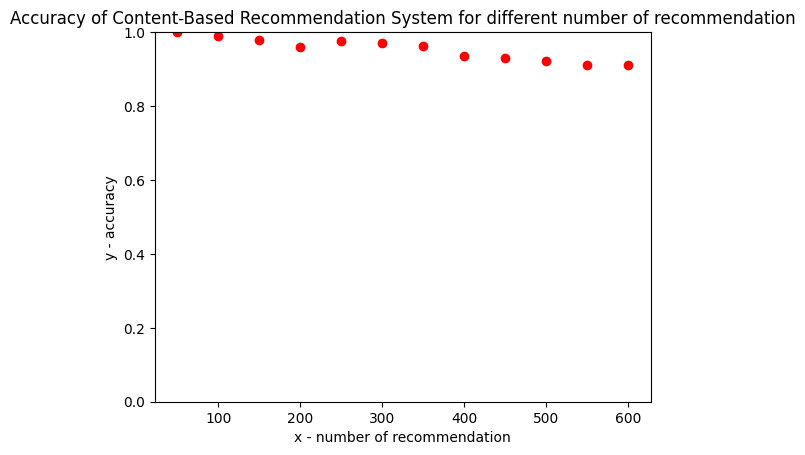

In [7]:
x_nb_recommendation = []
y_accuracy = []

for i in range(50,601,50):
    recommended_movies_weight_matrix = recommend_movies_weight_matrix(movies_df, moviesInput, ratings, i)
    temp_accuracy = recommend_movies_kmeans(movies_df, moviesInput, recommended_movies_weight_matrix, i)
    x_nb_recommendation.append(i)
    y_accuracy.append(temp_accuracy)

y_accuracy = [round(num, 5) for num in y_accuracy]  

print(x_nb_recommendation)
print(y_accuracy)

plt.plot(x_nb_recommendation, y_accuracy, 'ro')
plt.xlabel('x - number of recommendation')
plt.ylabel('y - accuracy')
plt.title("Accuracy of Content-Based Recommendation System for different number of recommendation")
plt.ylim([0, 1])

plt.show()



<h4>Recap of Content-Based recommender system</h4>

The content-based recommender system is a recommendation system that suggests items based on the similarity of the item's features to the user's preferences. In our case, we made our recommender in a way so that it would be able to include the user's ratings over the movies which are inputted into the system, allowing for more flexibility and customization over their recommendations. Our recommender system then recommends movies based on genres similarity, and puts more emphasis over those with a higher rating based on the input of the users.

A downside of our recommender system is that it is limited to recommending items that are similar to the inputted movies, and may not be able to recommend items which does not have the same genre scope. An alternative to that would be collaborative, where we match user's preference to other similar types of user ratings. Furthermore, since our database of movie is sparse, some movies have a large number of genre attached to it while others only have one genre. Due to the fact that we use a weighted matrix, this can greatly affect the accuracy of our recommender system since movies with multiple genres have more chance to be recommended, as the total sum is impacted by their multiple genres. A minor solution can be to give a very high rating to movies which are liked, as it would impact their sum in a way which makes the multiple genres less significant, or to put movies which are very disliked a rating of 0, which will nullify the impact of their multiple ratings as they will have a value of 0.